<a href="https://colab.research.google.com/github/nazmus007/transformers_test/blob/main/electra_sarcpol_run1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install -qq transformers

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import transformers

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification

import torch
import re
import numpy as np
import pandas as pd

import seaborn as sns

from pylab import rcParams

import matplotlib.pyplot as plt

from matplotlib import rc

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict

from textwrap import wrap

from torch import nn, optim

from torch.utils.data import Dataset, DataLoader

In [4]:
import torch.nn.functional as F

In [6]:
df_train = pd.read_csv("./drive/MyDrive/datasets/sarc_pol_train.csv")
df_train.head()

,Unnamed: 0,index,Tweet,Label
0,0,0,JUST YOU SHUT THE FUCK UP AND GET BACK TO TROO...,1
1,1,1,When all else fails blame Pepe,1
2,2,2,Well at least he is doing a white people drug .,1
3,3,3,I'm sure he will come into meetings with a com...,1
4,4,4,I'm so shocked,1


In [5]:
df_test= pd.read_csv("./drive/MyDrive/datasets/sarc_pol_test.csv")

In [7]:
df_val = pd.read_csv("./drive/MyDrive/datasets/sarc_pol_dev.csv")

In [ ]:
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 934 kB/s 


In [ ]:
import demoji
def demoji_text(text):
  d= demoji.findall(text)
  return d

In [ ]:
df_train['emoji_list'] = df_train['Tweet'].apply(demoji_text)

In [ ]:
f= list(filter(None, df_train['emoji_list']))

In [ ]:
print(f)

[{'🌲': 'evergreen tree'}, {'😂': 'face with tears of joy'}, {'😂': 'face with tears of joy'}, {'😍': 'smiling face with heart-eyes'}, {'😩': 'weary face'}, {'😍': 'smiling face with heart-eyes', '😘': 'face blowing a kiss', '😁': 'beaming face with smiling eyes', '🍗': 'poultry leg', '✊': 'raised fist', '🌽': 'ear of corn', '🍴': 'fork and knife'}, {'💫': 'dizzy', '✨': 'sparkles'}, {'😭': 'loudly crying face'}, {'😭': 'loudly crying face'}, {'😴': 'sleeping face'}, {'☺': 'smiling face'}, {'🌪': 'tornado'}, {'☺️': 'smiling face'}, {'☺': 'smiling face'}, {'😂': 'face with tears of joy'}, {'😈': 'smiling face with horns', '😩': 'weary face', '😜': 'winking face with tongue'}, {'😂': 'face with tears of joy'}, {'❤️': 'red heart', '👶': 'baby', '😩': 'weary face'}, {'😍': 'smiling face with heart-eyes'}, {'😊': 'smiling face with smiling eyes'}, {'🎤': 'microphone'}, {'⚓': 'anchor', '❤️': 'red heart'}, {'❤': 'red heart'}, {'😂': 'face with tears of joy'}, {'🏈': 'american football'}, {'😘': 'face blowing a kiss'}, {'😭

In [ ]:
all_keys = set().union(*(d.keys() for d in f))

In [ ]:
print(all_keys)

{'🐻', '🌅', '🖊', '😜', '😻', '🐷', '☀️', '🍏', '👉', '👼', '💫', '💙', '💡', '🌯', '📺', '⛪', '😆', '🌈', '🐜', '😂', '😫', '😱', '🌿', '🌌', '✂️', '👌', '👦', '➡', '🍒', '📤', '🚛', '🔐', '‼️', '😲', '🔋', '🤑', '🐯', '✏️', '🎺', '🎧', '😰', '🗽', '🍀', '🐧', '🤔', '🍂', '👦🏿', '⛷', '☃', '😥', '👎', '😈', '🇸🇸', '😇', '🔦', '🙎', '👨\u200d👩\u200d👦\u200d👦', '🍹', '🔒', '🕸', '😋', '🙏🏽', '✏', '👼🏿', '☝', '🎊', '💍', '🏦', '🐟', '💛', '😾', '📹', '🏹', '👸🏽', '💁', '✔', '✍', '🖖', '👉🏿', '🌶', '🐠', '🌪', '😎', '🍼', '📄', '🌧', '⚠️', '🍰', '👋🏻', '✝', '🎆', '👳', '🐊', '🐾', '🏆', '🐸', '👙', '♥️', '🐼', '⏳', '🗑', '☣', '🌤', '🔫', '😀', '🔊', '🚘', '💶', '👅', '🛏', '📖', '📝', '👫', '🍥', '⭕', '⚽', '🎂', '☁', '🐑', '😢', '🇨🇦', '😙', '🚮', '☁️', '☺', '🙍', '❤️', '😞', '💻', '🏿', '💸', '🌨', '💷', '😌', '💜', '🐀', '❣', '⏱', '💲', '🚶', '😓', '🙁', '©', '🌝', '🚬', '💧', '🚜', '😑', '😖', '🌠', '🐛', '🏒', '🎵', '🐔', '😔', '🆘', '🍔', '🙀', '🎮', '⛈', '📵', '🕷', '❌', '✈️', '😒', '😏', '🌳', '🔬', '🐏', '😣', '🌎', '🎄', '⭐', '✅', '🖐', '☄', '😽', '🙆🏻', '🙂', '🇪🇸', '🎙', '💕', '🌲', '👀', '🚡', '🏇', '🌂', '😡', '✔️', '🍚', '♐', '😛'

In [ ]:
len(all_keys)

453

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.3 MB/s 


In [8]:
PRE_TRAINED_MODEL_NAME = 'google/electra-base-discriminator'

In [9]:
from transformers import ElectraTokenizer

tokenizer = ElectraTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
#tokenizer.add_tokens(['⭕', '♐', '👋', '👴', '🤔', '😳', '✔', '🎶', '😂', '😪', '⛽', '😤', '🏋', '💌', '🌏', '♥', '🎙', '💐', '🏇', '☃', '👑', '📄', '🙁', '🐊', '🌸', '☹', '💦', '⏲', '🙏🏽', '😉', '🍅', '🎮', '📹', '😄', '🎉', '😩', '😮', '🍂', '🙎', '😟', '😫', '🔫', '🙏', '😀', '⚡', '💁', '😅', '👎', '®', '❄', '🌧', '😌', '🏹', '✏️', '👍', '⏳', '💸', '👦', '🏽', '😖', '👼', '🐥', '🐜', '🌊', '😼', '✂️', '😰', '🍝', '💀', '🍿', '🙇', '🚣', '💎', '😍', '🍋', '👲', '🙌🏼', '🔒', '🌟', '📜', '💋', '⚽', '☀', '👋🏻', '🌌', '🏵', '🍀', '🚊', '🍣', '😊', '👳', '🙃', '😒', '🍻', '🏦', '📻', '🙄', '👩', '🌲', '🍏', '😞', '🔋', '👉', '🐸', '🙆🏻', '🆓', '🔮', '🍦', '💝', '🆙', '🚛', '😆', '☕', '🏰', '🆗', '🐣', '🌰', '🤑', '🔦', '🕸', '👅', '🅰', '🌈', '🎼', '🌝', '❗', '🔴', '🚐', '🌎', '😋', '🍟', '🌵', '💁🏼', '✖', '🍰', '🍹', '💷', '🚮', '🍇', '✅', '🏈', '👧', '👎🏼', '🤕', '👐', '🔬', '™', '🚬', '🚌', '🐼', '🚂', '👱', '📝', '‼️', '🌙', '🖊', '🍕', '😘', '💕', '🍗', '🇸🇸', '👂', '💖', '📈', '🏐', '⛄', '♥️', '🍸', '👿', '🎅', '🐱', '🤐', '🚜', '🐨', '🍚', '🎭', '⏱', '🚲', '➰', '⛪', '🍒', '😸', '🙍', '💯', '😃', '🎨', '💲', '🔷', '🗽', '👒', '🍴', '😣', '👫', '🚙', '🙂', '💈', '👈', '🐅', '🍁', '📓', '😢', '👉🏿', '🈵', '💄', '🍫', '💙', '🐍', '⚠️', '🖖', '👆', '✍', '🍑', '⛷', '♈', '🐑', '😻', '🍾', '🍍', '🎈', '😗', '✒️', '🖼', '👗', '👨', '😝', '😾', '📥', '🐧', '🌳', '❤', '😚', '🎄', '👵', '👸🏽', '➡️', '✂', '😐', '😎', '💛', '👨\u200d👩\u200d👦\u200d👦', '⬆️', '©', '❌', '⚓', '🏡', '🚡', '😡', '😱', '📀', '⛵', '🐿', '😓', '😁', '🐘', '🍔', '⭐', '🐾', '🏒', '🍼', '🎯', '🐚', '😔', '❣', '🦃', '💧', '👍🏼', '🆒', '🐟', '💍', '💪', '🚗', '💓', '😽', '🖐', '😿', '💑', '😴', '🚫', '👀', '❄️', '🍃', '✌', '🐷', '🌪', '😹', '🔓', '🌺', '😈', '😛', '🌴', '☄', '🐳', '💗', '🌻', '🐀', '😨', '😙', '💶', '😑', '🐰', '🇪🇸', '🔐', '⛈', '😶', '🇮🇹', '❓', '😦', '🌼', '🌤', '🖕🏼', '➡', '🌨', '⛸', '👪', '📖', '🍎', '👸', '🐗', '🆘', '🗣', '🎁', '🌯', '🏥', '🐏', '🔕', '😧', '🕷', '☝️', '😕', '🇯🇵', '👓', '🔥', '🍵', '✨', '🔱', '📵', '📺', '💳', '🇺🇸', '👄', '💫', '🚑', '😲', '🎆', '🙀', '😜', '📱', '🌿', '❤️', '🍭', '✏', '☺', '⚫', '🎺', '🌍', '🛏', '🎵', '0⃣', '🚘', '💣', '🏃', '😇', '🚪', '🎂', '😥', '😠', '😺', '🔞', '☝', '🌃', '🔊', '🏆', '🎊', '🍥', '🚶', '☁️', '🐔', '☔', '😯', '🌠', '👙', '🎤', '🌬', '✌️', '☮', '🦄', '💵', '🍺', '🍆', '🗑', '📤', '🕰', '😷', '🐛', '🌅', '✊', '🚔', '☹️', '🍓', '🙏🏼', '👠', '🐯', '☁', '🗿', '🎇', '💟', '💻', '💞', '🇨🇦', '✝', '🎧', '✔️', '🐒', '💁🏽', '🐮', '🌂', '1️⃣', '🌽', '✈️', '✋', '💡', '🙌', '👨\u200d👩\u200d👧\u200d👧', '🕑', '🌶', '🎎', '👶', '💩', '🏏', '🏿', '☺️', '🌞', '🙈', '💜', '👌', '🇬🇧', '🐠', '👼🏿', '☣', '☀️', '👻', '🎑', '🎹', '😭', '🌀', '🙊', '👦🏿', '😏', '🅿️', '🐻', '🎥', '👔', '🚽'])


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

In [ ]:
token_lens = []

for txt in df_train['Tweet']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


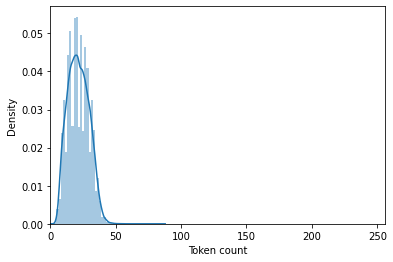

In [ ]:
import seaborn as sns

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [10]:
df_train_X= list(df_train["Tweet"])
df_val_X = list(df_val["Tweet"])

In [11]:
y_train = list(df_train["Label"])

y_val = list(df_val["Label"])

y_test = list(df_test["Label"])

In [12]:
X_train_tokenized = tokenizer(df_train_X, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(df_val_X, padding=True, truncation=True, max_length=512)

In [13]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [14]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
from transformers import ElectraForSequenceClassification

model = ElectraForSequenceClassification.from_pretrained(
    "google/electra-base-discriminator", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

#model.resize_token_embeddings(len(tokenizer))

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

In [17]:
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [18]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)


    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [19]:
output_dir='./drive/MyDrive/savedmodel_meta/sarcpol_electra'

In [20]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="steps",
    weight_decay = 0.01,
    logging_steps = 500,
    eval_steps = 500,
    logging_dir='./logs/electra_electra',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    seed=123,
    load_best_model_at_end=True,
    #save_total_limit=1,
    learning_rate = 2e-5
)

In [21]:
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args= args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 10934
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5468


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.626500,0.593129,0.710315,0.735223,0.661326,0.696319
1000,0.586000,0.546265,0.740307,0.755985,0.713037,0.733883
1500,0.539300,0.577535,0.739210,0.756610,0.708667,0.731854
2000,0.445600,0.587755,0.739576,0.721663,0.783685,0.751397
2500,0.455100,0.586524,0.730432,0.695572,0.823744,0.754251
3000,0.391000,0.830956,0.711046,0.665531,0.853605,0.747926
3500,0.321300,0.881318,0.724214,0.695762,0.801165,0.744753
4000,0.350500,0.841441,0.708486,0.664384,0.847779,0.744960
4500,0.232400,1.072832,0.734455,0.714665,0.784414,0.747917
5000,0.257800,1.125048,0.733358,0.708820,0.796067,0.749914


***** Running Evaluation *****
  Num examples = 2734
  Batch size = 8
Saving model checkpoint to ./drive/MyDrive/savedmodel_meta/sarcpol_electra/checkpoint-500
Configuration saved in ./drive/MyDrive/savedmodel_meta/sarcpol_electra/checkpoint-500/config.json
Model weights saved in ./drive/MyDrive/savedmodel_meta/sarcpol_electra/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./drive/MyDrive/savedmodel_meta/sarcpol_electra/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./drive/MyDrive/savedmodel_meta/sarcpol_electra/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 2734
  Batch size = 8
Saving model checkpoint to ./drive/MyDrive/savedmodel_meta/sarcpol_electra/checkpoint-1000
Configuration saved in ./drive/MyDrive/savedmodel_meta/sarcpol_electra/checkpoint-1000/config.json
Model weights saved in ./drive/MyDrive/savedmodel_meta/sarcpol_electra/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./drive/My

TrainOutput(global_step=5468, training_loss=0.404357925504337, metrics={'train_runtime': 969.5165, 'train_samples_per_second': 45.111, 'train_steps_per_second': 5.64, 'total_flos': 3685972107861120.0, 'train_loss': 0.404357925504337, 'epoch': 4.0})

In [26]:
X_test = list(df_test["Tweet"])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized,y_test)

# Load trained model
model_path = "./drive/MyDrive/savedmodel_meta/sarcpol_electra/checkpoint-4500"

model = ElectraForSequenceClassification.from_pretrained(model_path, num_labels=2)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

loading configuration file ./drive/MyDrive/savedmodel_meta/sarcpol_electra/checkpoint-4500/config.json
Model config ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weig

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred,labels=[1,0])) #chkpoint2500

              precision    recall  f1-score   support

           1       0.70      0.82      0.76      1703
           0       0.78      0.65      0.71      1703

    accuracy                           0.73      3406
   macro avg       0.74      0.73      0.73      3406
weighted avg       0.74      0.73      0.73      3406



In [27]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred,labels=[1,0]))#chkpoint4500

              precision    recall  f1-score   support

           1       0.72      0.79      0.75      1703
           0       0.77      0.69      0.73      1703

    accuracy                           0.74      3406
   macro avg       0.74      0.74      0.74      3406
weighted avg       0.74      0.74      0.74      3406



In [28]:
class_names = [1,0]

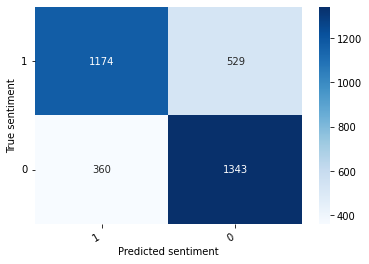

In [29]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)